# 1: Logistic Fish Population Model (Time-Only ODE)

This notebook analyzes single-species fish population growth using the logistic ordinary differential equation.
It compares analytic and numerical solutions, validates their agreement, and generates core diagnostic plots.

## Model

The dimensional logistic ODE is:

$$
\frac{dx}{dt} = r x \left(1 - \frac{x}{K}\right), \quad r>0,\ K>0, \quad x(0)=x_0>0
$$

**Non-dimensionalisation.** Set $\tilde{x} = x/K$ and $\tau = rt$. Then $dx/dt = Kr\, d\tilde{x}/d\tau$, and dividing through by $Kr$:

$$
\frac{d\tilde{x}}{d\tau} = \tilde{x}(1 - \tilde{x})
$$

This dimensionless ODE has **no free parameters** — $r$ and $K$ only appear via the initial condition $\tilde{x}_0 = x_0/K$ and the timescale $\tau = rt$.

**Analytic solution:**

$$
\tilde{x}(\tau) = \frac{1}{1 + \left(\dfrac{1-\tilde{x}_0}{\tilde{x}_0}\right)e^{-\tau}}
$$

**Equilibria:** $\tilde{x}^*=0$ (unstable) and $\tilde{x}^*=1$ (stable, corresponds to $x^*=K$).


## Quick-Look Plot

This is a minimal first view of logistic growth using only the analytic formula.
It is intentionally independent of the full validation workflow below.


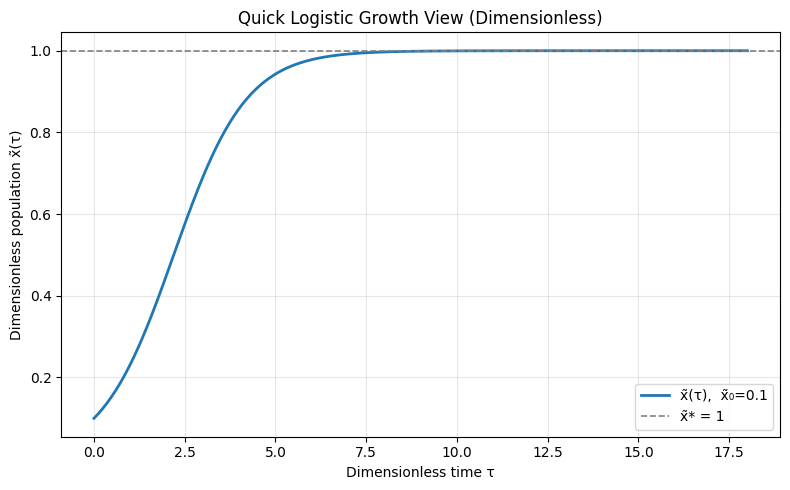

In [13]:
import numpy as np
from matplotlib import pyplot as plt

# Dimensional reference parameters
r_quick: float = 0.6
K_quick: float = 1000.0
x0_quick: float = 100.0

# Convert to dimensionless
x0_nd: float = x0_quick / K_quick          # x̃₀ = 0.1
tau_end: float = r_quick * 30.0             # τ_end = 18.0

tau = np.linspace(0.0, tau_end, 300)

# ND analytic solution: x̃(τ) = 1 / (1 + ((1-x̃₀)/x̃₀) * exp(-τ))
x_nd = 1.0 / (1.0 + ((1.0 / x0_nd) - 1.0) * np.exp(-tau))

plt.figure(figsize=(8, 5))
plt.plot(tau, x_nd, linewidth=2.0, label=f"x\u0303(\u03c4),  x\u0303\u2080={x0_nd:g}")
plt.axhline(1.0, color="gray", linestyle="--", linewidth=1.2, label="x\u0303* = 1")
plt.title("Quick Logistic Growth View (Dimensionless)")
plt.xlabel("Dimensionless time \u03c4")
plt.ylabel("Dimensionless population x\u0303(\u03c4)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


## Main Execution

Run the code cell below to:
- validate RK45 against the analytic solution across multiple parameter sets,
- check positivity and report warnings if violations occur,
- save the main figures as PNG files and display them.

ND validation cases (r=1, K=1, x̃₀):
  x̃₀ = 0.1000
  x̃₀ = 0.1000
  x̃₀ = 1.2500
  x̃₀ = 0.9667


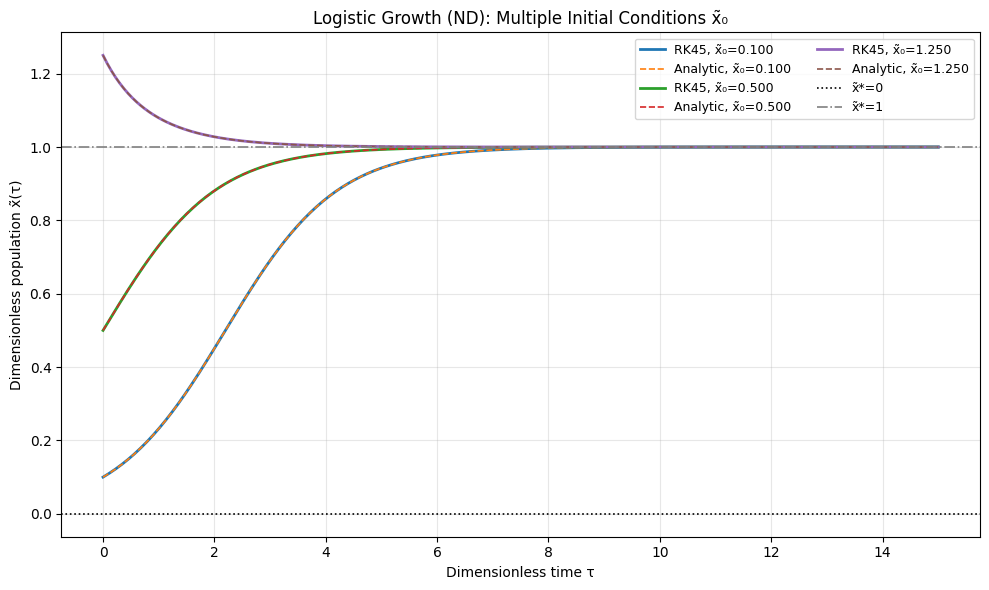

In [14]:
import numpy as np
from matplotlib import pyplot as plt

from validation import run_validation_suite
from plotting import plot_initial_condition_comparison

# ── Original dimensional cases (kept for reference) ──────────────────
# (r, K, x0): (0.3,500,50), (0.8,1000,100), (1.2,1200,1500), (0.5,300,290)
VALIDATION_CASES_DIM: list[tuple[float, float, float]] = [
    (0.3, 500.0, 50.0),
    (0.8, 1000.0, 100.0),
    (1.2, 1200.0, 1500.0),
    (0.5, 300.0, 290.0),
]

# ── Convert to ND: r→1, K→1, x0→x̃₀=x0/K ──────────────────────────
VALIDATION_CASES_ND: list[tuple[float, float, float]] = [
    (1.0, 1.0, round(x0 / K, 6)) for r, K, x0 in VALIDATION_CASES_DIM
]
print("ND validation cases (r=1, K=1, x̃₀):")
for r, K, x0_nd in VALIDATION_CASES_ND:
    print(f"  x\u0303\u2080 = {x0_nd:.4f}")

# ── Common τ_eval (ND dynamics converge well within τ=15) ────────────
TAU_END: float = 15.0
N_POINTS: int = 400
NEGATIVITY_TOL: float = -1e-12
tau_eval = np.linspace(0.0, TAU_END, N_POINTS)

_ = run_validation_suite(cases=VALIDATION_CASES_ND, t_eval=tau_eval,
                          negativity_tol=NEGATIVITY_TOL)

# ── IC comparison: x̃₀ ∈ {0.1, 0.5, 1.25} ────────────────────────────
# r=1, K=1 → plot_initial_condition_comparison produces the ND solution directly
X0_LIST_ND: list[float] = [0.1, 0.5, 1.25]

_ = plot_initial_condition_comparison(
    t_eval=tau_eval, r=1.0, K=1.0, x0_list=X0_LIST_ND,
)

# Note: in the dimensionless ODE dx̃/dτ = x̃(1-x̃) there are no free parameters.
# An r-sweep in dimensional form collapses to a single ND curve (different r values
# only rescale the time axis: τ = r·t). The IC comparison above is the natural ND sweep.

plt.show()


## 2: Logistic Growth with Fishing (Harvesting)

We now include constant proportional harvesting. Setting $\tilde{x} = x/K$ and $\tau = rt$ as before, with dimensionless harvest rate $\tilde{h} = h/r$, the dimensional ODE

$$
\frac{dx}{dt} = r x \left(1 - \frac{x}{K}\right) - h x
$$

becomes the **dimensionless harvesting ODE**:

$$
\frac{d\tilde{x}}{d\tau} = \tilde{x}(1 - \tilde{x}) - \tilde{h}\,\tilde{x} = \tilde{x}\!\left(1 - \tilde{x} - \tilde{h}\right)
$$

**Equilibria:**
- $\tilde{x}^* = 0$ (always an equilibrium; stable when $\tilde{h} \ge 1$)
- $\tilde{x}^* = 1 - \tilde{h}$ (positive equilibrium when $\tilde{h} < 1$; stable)

**Maximum Sustainable Yield:** achieved at $\tilde{h}_{\text{MSY}} = \tfrac{1}{2}$, giving $\tilde{x}^*_{\text{MSY}} = \tfrac{1}{2}$.


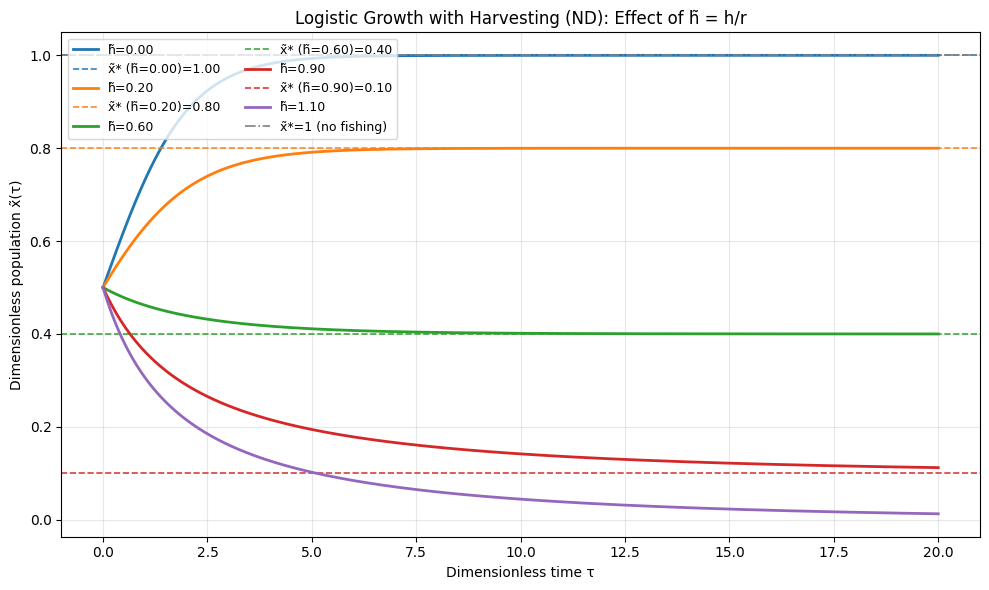

In [15]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp

from ode_models import harvested_rhs

# ── Dimensional reference parameters ─────────────────────────────────
K_h: float = 1000.0
r_h: float = 0.50
x0_h: float = 500.0

# ── Convert to ND: x̃₀ = x0/K,  τ_end = r*T_end,  h̃ = h/r ──────────
x0_nd_h: float = x0_h / K_h               # x̃₀ = 0.5
tau_end_h: float = r_h * 40.0             # τ_end = 20.0
tau_h = np.linspace(0.0, tau_end_h, 801)

# Dimensionless harvest rates h̃ = h/r
h_tilde_values: list[float] = [0.00, 0.20, 0.60, 0.90, 1.10]

fig_c, ax_c = plt.subplots(figsize=(10, 6))

for h_tilde in h_tilde_values:
    # Pass r=1, K=1, h=h̃ to harvested_rhs → gives ND RHS dx̃/dτ = x̃(1-x̃) - h̃x̃
    sol = solve_ivp(
        fun=lambda t, y, ht=h_tilde: harvested_rhs(t=t, x=y, r=1.0, K=1.0, h=ht),
        t_span=(float(tau_h[0]), float(tau_h[-1])),
        y0=np.array([x0_nd_h], dtype=float),
        t_eval=tau_h,
        method="RK45",
        rtol=1e-9,
        atol=1e-12,
    )
    if not sol.success:
        raise RuntimeError(f"solve_ivp failed for h\u0303={h_tilde:.2f}: {sol.message}")

    x_nd_sol = sol.y[0]
    line, = ax_c.plot(tau_h, x_nd_sol, linewidth=2.0, label=f"h\u0303={h_tilde:.2f}")

    if h_tilde < 1.0:
        x_star_nd = 1.0 - h_tilde
        ax_c.axhline(
            x_star_nd,
            color=line.get_color(),
            linestyle="--",
            linewidth=1.2,
            alpha=0.9,
            label=f"x\u0303* (h\u0303={h_tilde:.2f})={x_star_nd:.2f}",
        )

ax_c.axhline(1.0, color="gray", linestyle="-.", linewidth=1.2, label="x\u0303*=1 (no fishing)")
ax_c.set_title("Logistic Growth with Harvesting (ND): Effect of h\u0303 = h/r")
ax_c.set_xlabel("Dimensionless time \u03c4")
ax_c.set_ylabel("Dimensionless population x\u0303(\u03c4)")
ax_c.grid(True, alpha=0.3)
ax_c.legend(fontsize=9, ncol=2)
fig_c.tight_layout()
plt.show()
